# HW 8-1: Box Model


In [1]:
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import xarray as xr
import pandas as pd
import scipy
from datetime import datetime, timedelta
import time
import seaborn
import matplotlib.dates as mdates
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
import math
import netCDF4 as nc
import requests

# Import K's code for calculating the coefficients of the carb system
import calc_coeffs as co2
import H_poly as hpoly
import H_poly2 as hpoly2
from importlib import reload
import warnings
# warnings.filterwarnings('ignore')
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

# Define time step
1 year steps for 100 years

In [48]:
time = np.arange(0,100,1)
time

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

# define boxes
of the form:
```python
dim = [box1, box2, box3]
```

In [17]:
dx = np.array([17e6, 17e6, 17e6])   # longitude (m)
dy = np.array([8e6, 8e6, 16e6])     # latitude (m)
dz = np.array([100, 100, 5000])     # depth (m)
V = dx * dy * dz                    # volume of each box (m^3)

# Coefficients

In [19]:
phi = 20e6         # m^3/s
k13 = 1e6          # m^3/s
k23 = 1e6          # m^3/s
k12 = 10e6         # m^3/s

# Steady state fluxes
k31 = k13          # m^3/s
k32 = k23          # m^3/s
k21 = k12          # m^3/s

# Solve with loop
Given that all the boxes have the same initial concentration and all the fluxes are in steady state (i.e. the flow from box 1 to box 3 is the same as the flow from box 3 to box 1, and this holds across all boxes), I expect the concentration to not change over time. 

In [65]:
# time step size
dt = 1

# Arrays to store concentrations over time
C1 = np.zeros(len(time))
C2 = np.zeros(len(time))
C3 = np.zeros(len(time))

# Initial values
C1_0 = 1
C2_0 = 1
C3_0 = 1

for t in time:
    # Calculate rate of change
    dC1dt = (1/V[0])*(phi*(C3[t]-C1[t]) + k31*(C3[t]-C1[t]) + k21*(C2[t]-C1[t]))
    dC2dt = (1/V[1])*(phi*(C1[t]-C2[t]) + k12*(C1[t]-C2[t]) + k32*(C3[t]-C2[t]))
    dC3dt = (1/V[2])*(phi*(C2[t]-C3[t]) + k23*(C2[t]-C3[t]) + k13*(C1[t]-C3[t]))
    
    # Calculate concentration at time t
    C1[t] = C1_0 + dC1dt * dt
    C2[t] = C2_0 + dC2dt * dt
    C3[t] = C3_0 + dC3dt * dt
    
    # Set initial (aka C(t-1)) to latest solution
    C1_0 = C1[t]
    C2_0 = C2[t]
    C2_0 = C2[t]

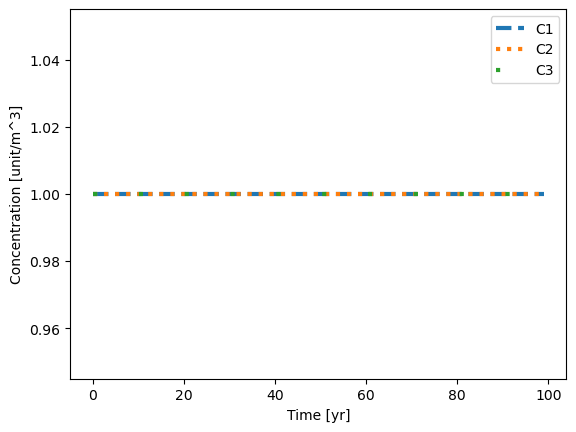

In [66]:
plt.plot(time, C1, label = 'C1',ls = 'dashed', lw = 3)
plt.plot(time, C2, label = 'C2', ls = 'dotted', lw = 3)
plt.plot(time, C3, label = 'C3', ls = (0, (1, 10)), lw = 3)
plt.xlabel('Time [yr]')
plt.ylabel('Concentration [unit/m^3]')
plt.legend()

I guess I was right.

# $C_{\text{total}}$
Given that there are no sources or sinks of C and that C is only being advected from one box to another, I expect $C_{\text{total}}$ to remain constant over time.

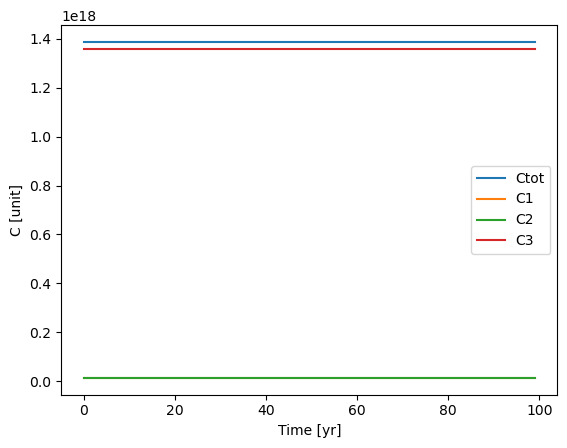

In [68]:
Ctot = C1 * V[0] + C2 * V[1] + C3 * V[2]
plt.plot(time, Ctot, label = 'Ctot')
plt.plot(time, C1 * V[0], label = 'C1')
plt.plot(time, C2 * V[1], label = 'C2')
plt.plot(time, C3 * V[2], label = 'C3')
plt.ylabel('C [unit]')
plt.xlabel('Time [yr]')
plt.legend()

Indeed the total amount stays constant over time. The total amount in each box is constant through time. The amount in C3 is greater than the amount of C1 and C2, since the concentrations are the same across boxes but the box 3 is much larger.